In [183]:
import numpy as np
import camb
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm
from progressbar import ProgressBar
import random
from mpl_toolkits.mplot3d import Axes3D

### Example code from Pr. Sievers for the CMB:

In [2]:
def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

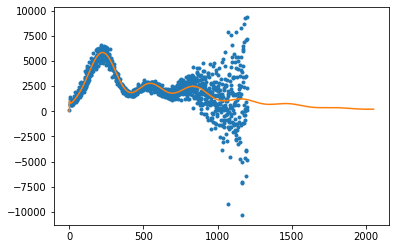

In [3]:
plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')

cmb=get_spectrum(pars)
plt.plot(cmb)

# HW3

# Question 1:

### a)

We have the equation of a rotational paraboloid:

$$z - z_0 = a( (x-x_0)^2 + (y-y0)^2 )$$

$$z = ax^2 - 2ax_0x +ax_0^2 +ay^2 -2ay_0y +ay_0^2 +z_0$$

Now let's define new variables and parameters:

$x_1 = x^2 + y^2$; $x_2 = x$; $x_3 = y$

$a_0 = ax_0^2 +ay_0^2 + z_0$; $a_1 = a$; $a_2 = -2ax_0$; $a_3 = -2ay_0$

We can now rewrite the above as equation as:

$$z = x_1 a_1 + x_2 a_2 + x_3 a_3 + a_0 $$

### b)

In [148]:
dish = np.loadtxt('dish_zenith.txt', delimiter=' ')
x = dish[:,0]
y = dish[:,1]
z = dish[:,2]

In [179]:
#define the function:
f = np.array([np.ones(len(x)), x**2 + y**2, x, y]).transpose()

#Least square fit:
lhs = f.transpose()@f
rhs = f.transpose()@z
mat = np.linalg.inv(lhs)@(rhs)
pred = f@mat

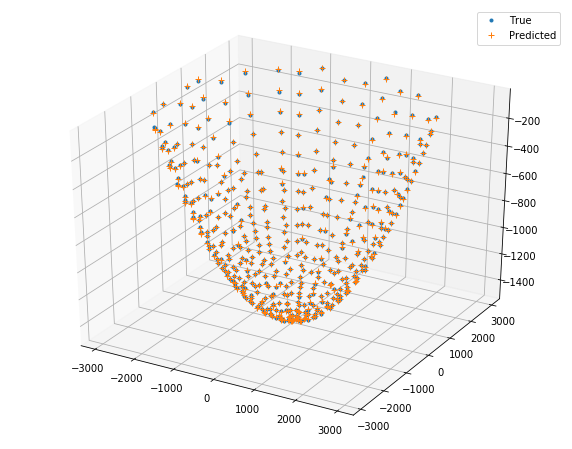

In [196]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xs=x,ys=y,zs=z,marker='.',linestyle='', label='True')
ax.plot(xs=x, ys=y, zs=pred, marker='+', linestyle='', label='Predicted')
ax.legend()

Looking at plot above, the predicted z values by the fit and the true z values seem to be in good agreement.

In [210]:
print('The best fit parameters are:')
print(f'a_0 = {mat[0]:.2f}')
print(f'a_1 = {mat[1]:.5f}')
print(f'a_2 = {mat[2]:.5f}')
print(f'a_3 = {mat[3]:.3f}')

The best fit parameters are:
a_0 = -1512.31
a_1 = 0.00017
a_2 = 0.00045
a_3 = -0.019


In [202]:
#going back to the parameters:
a = mat[1]
x0 = - mat[2]/(2*a)
y0 = - mat[3]/(2*a)
z0 = mat[0] - (mat[2]**2/(4*a)) - (mat[3]**2/(4*a))

In [209]:
print('The true parameters are:')
print(f'a = {a:.5f}')
print(f'x_0 = {x0:.2f}')
print(f'y_0 = {y0:.2f}')
print(f'z_0 = {z0:.2f}')

The true parameters are:
a = 0.00017
x_0 = -1.36
y_0 = 58.22
z_0 = -1512.88


### c)

To get the noise in the data:

In [199]:
sig = np.std(z-pred)
N=sig**2*np.eye(len(x))
Ninv=np.linalg.inv(N) #this is the noise

new_lhs = f.transpose()@Ninv@f
err = np.sqrt(np.diag(np.linalg.inv(lhs)))

In [205]:
print('The error on parameter a is:')
print(f'a = {a} +/- {err[1]}')

The error on parameter a is:
a = 0.0001667044547740132 +/- 1.7121337434320458e-08


If a parabola that goes through (0,0) can be written as $y = x^2/4f$, then we have:

$$f = \frac{1}{4a} $$

And using Taylor expansion, the error in f is:

$$\delta_f = \delta_a abs(f'(a)) \to \delta_f = \delta_a \frac{1}{4a^2}$$

In [208]:
f_l = 1/(4*a)
err_f_l = err[1]*1/(4* a**2)
print(f'The focal length is f={f_l:.2f} +/- {err_f_l:.2f}')

The focal length is f=1499.66 +/- 0.15


# Question 2:

In [4]:
#Define the χ square:
def ChiSq(model, data, error):
    return ((model - data)**2/error**2).sum()

In [5]:
#cosmological parameters
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96]) 

#WMAP data
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') 
index = wmap[:,0].astype(int)
data = wmap[:,1]
err = wmap[:,2]

#model cmb
cmb=get_spectrum(pars)
model = cmb[index]

#Chi square computation
χ = ChiSq(model, data, err)
print(f"The Chi square is: {χ}")

The Chi square is: 1588.2376465826746


This agrees with the value $\chi^2 = 1588$ given in the assignment.

# Question 3:

In [6]:
#This is the same code as the prof's, just slightly modified to account for the constant vs floating τ.
def get_spectrum_new(pars,lmax=2000):
    
    if len(pars)==5:
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=0.05
        As=pars[3]
        ns=pars[4] 
    
        pars=camb.CAMBparams()
        pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
        pars.InitPower.set_params(As=As,ns=ns,r=0)
        pars.set_for_lmax(lmax,lens_potential_accuracy=0)
        results=camb.get_results(pars)
        powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
        cmb=powers['total']
        tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
        
    else: 
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=pars[3]
        As=pars[4]
        ns=pars[5] 
    
        pars=camb.CAMBparams()
        pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
        pars.InitPower.set_params(As=As,ns=ns,r=0)
        pars.set_for_lmax(lmax,lens_potential_accuracy=0)
        results=camb.get_results(pars)
        powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
        cmb=powers['total']
        tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
            
    return tt

In [220]:
p1=np.asarray([65,0.02,0.1,2e-9,0.96]) #array of parameters for constant τ
p2 = np.asarray([65,0.02,0.1,0.05,2e-9,0.96]) #array of parameters for floating τ

#WMAP data
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') 
index = wmap[:,0].astype(int)
data = wmap[:,1]
err = wmap[:,2]

In [8]:
#define function to get the gradient:
def Grad(function, p, lmax=2000, factor=1000):
    grad = np.zeros([len(cmb), len(p)])
    
    for i in range(len(p)):
        
        p_p = p.copy()
        p_m = p.copy()
        
        δ = p[i]/factor #create increments
    
        p_p[i] = p[i] + δ
        p_m[i] = p[i] - δ
        
        deriv = (function(p_p) - function(p_m))/(2*δ)
        grad[:,i] = deriv
    return grad

### Plot of the derivatives:

To show the robustness of the derivatives, I plotted the partial derivative of $H_0$ and $w_ch^2$ for different values of $\delta$:

In [9]:
d1 = Grad(get_spectrum_new,p2, factor = 1000)[index,:] #this is the step size used later on for the CMB fit.

In [10]:
d2 = Grad(get_spectrum_new,p2, factor = 500)[index,:]

In [11]:
d3 = Grad(get_spectrum_new,p2, factor = 250)[index,:]

In [12]:
d4 = Grad(get_spectrum_new,p2, factor = 750)[index,:]

In [13]:
d5 = Grad(get_spectrum_new,p2, factor = 10)[index,:]

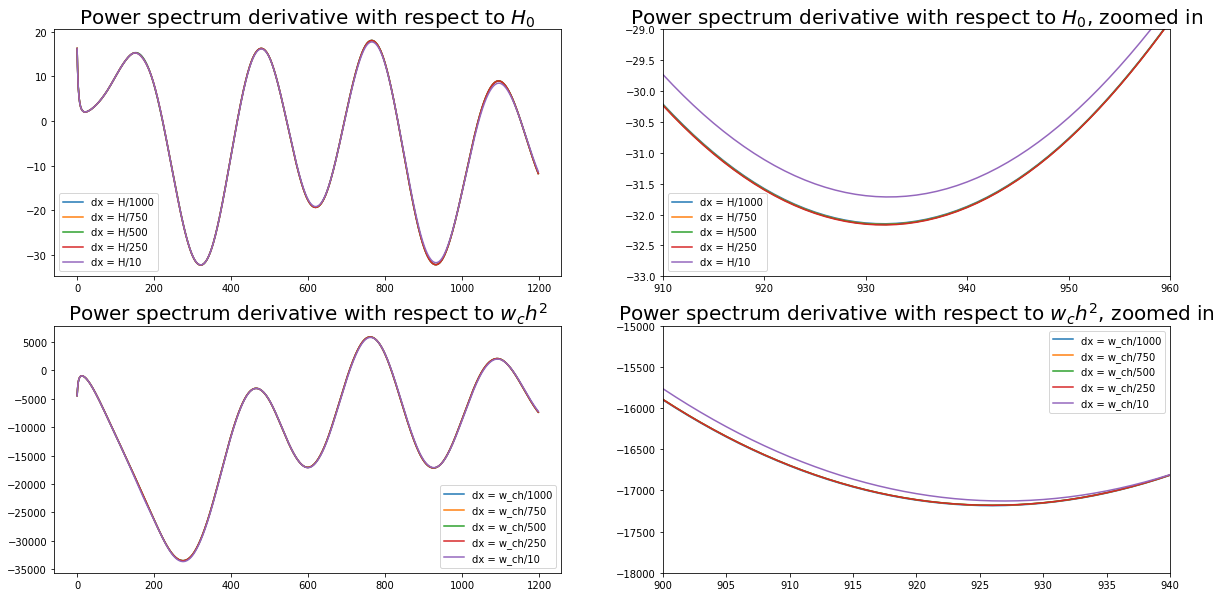

In [216]:
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
plt.plot(d1.transpose()[0], label='dx = H/1000')
plt.plot(d4.transpose()[0], label='dx = H/750')
plt.plot(d2.transpose()[0], label='dx = H/500')
plt.plot(d3.transpose()[0], label='dx = H/250')
plt.plot(d5.transpose()[0], label='dx = H/10')
plt.title(r'Power spectrum derivative with respect to $H_0$', fontsize=20)
plt.legend()

plt.subplot(2,2,2)
plt.plot(d1.transpose()[0], label='dx = H/1000')
plt.plot(d4.transpose()[0], label='dx = H/750')
plt.plot(d2.transpose()[0], label='dx = H/500')
plt.plot(d3.transpose()[0], label='dx = H/250')
plt.plot(d5.transpose()[0], label='dx = H/10')
plt.xlim(910, 960)
plt.ylim(-33,-29)
plt.title(r'Power spectrum derivative with respect to $H_0$, zoomed in', fontsize=20)
plt.legend()


plt.subplot(2,2,3)
plt.plot(d1.transpose()[2], label='dx = w_ch/1000')
plt.plot(d4.transpose()[2], label='dx = w_ch/750')
plt.plot(d2.transpose()[2], label='dx = w_ch/500')
plt.plot(d3.transpose()[2], label='dx = w_ch/250')
plt.plot(d5.transpose()[2], label='dx = w_ch/10')
plt.title(r'Power spectrum derivative with respect to $w_ch^2$', fontsize=20)
plt.legend()

plt.subplot(2,2,4)
plt.plot(d1.transpose()[2], label='dx = w_ch/1000')
plt.plot(d4.transpose()[2], label='dx = w_ch/750')
plt.plot(d2.transpose()[2], label='dx = w_ch/500')
plt.plot(d3.transpose()[2], label='dx = w_ch/250')
plt.plot(d5.transpose()[2], label='dx = w_ch/10')
plt.xlim(900, 940)
plt.ylim(-18000,-15000)
plt.title(r'Power spectrum derivative with respect to $w_ch^2$, zoomed in', fontsize=20)
plt.legend()

We can see that for various step sizes, the partial derivative does not change so much (except when $\delta=param/10$), therefore we can safely assume that the deriatives are robust for $\delta=param/1000$.

In [15]:
#Define minimizer:
def NLM(param, λ=1, χ_0=2000):
    
    p0 = param.copy()

    for j in range(10):
        ###model cmb
        model=get_spectrum_new(p0)[index]
    
    
        ###gradient of cmb
        grad = Grad(get_spectrum_new,p0)[index,:]
    
        r = data-model
        χ2 = ChiSq(model, data, err)
        print(f'The Chi square is {χ2}')
        noise = np.diag(1/(err**2))
        
        
        ###if the difference in chi square is below 0.1, the fit converged and the code stops
        if np.abs(χ2 - χ_0) < 0.1:
            cov = np.linalg.inv(lhs) #covariance matrix
            p_err = np.sqrt(np.diag(cov)) #error on parameters from the covariance matrix
                
            if len(p0) == 5:
                print(f'The final parameters are:')
                print(f'H0={p0[0]:.1f}+/-{p_err[0]:.1f}')
                print(f'w_bh={p0[1]:.4f}+/-{p_err[1]:.4f}')
                print(f'w_ch={p0[2]:.3f}+/-{p_err[2]:.3f}')
                print(f'tau = 0.05')
                print(f'A_s={p0[3]}+/-{p_err[3]}')
                print(f'n_s={p0[4]:.3f}+/-{p_err[4]:.3f}')
                return cov, p0
            
            else:
                print(f'The final parameters are:')
                print(f'H0={p0[0]:.1f}+/-{p_err[0]:.1f}')
                print(f'w_bh={p0[1]:.4f}+/-{p_err[1]:.4f}')
                print(f'w_ch={p0[2]:.3f}+/-{p_err[2]:.3f}')
                print(f'tau ={p0[3]:.4f}+/-{p_err[3]:.4f}')
                print(f'A_s={p0[4]}+/-{p_err[4]}')
                print(f'n_s={p0[5]:.3f}+/-{p_err[5]:.3f}')
                return cov, p0
           
                            
        ### If the step made the Chi square better, decrease λ and use fitted parameters to go on:
        elif χ2 < χ_0: 
            χ_0 = χ2
            λ = λ/100
            p = p0.copy()
            grad = Grad(get_spectrum_new,p)[index,:]
    
                            
        ### If it got worse, increase λ and try again:
        else: 
            λ = 50*λ
            p0 = param.copy()
        
                            
        ###least square fit
        r=np.matrix(r).transpose()
        grad=np.matrix(grad)
    
        lhs=grad.transpose()*noise*grad
        lhs+=λ*np.diag(np.diag(lhs))
        rhs=grad.transpose()*noise*r
        dp=np.linalg.inv(lhs)*(rhs)
    
        for jj in range(len(p0)):
            p0[jj]=p0[jj]+dp[jj]
        
        if len(p0) == 5:
            print (f'The parameters are: H0={p0[0]}, w_bh={p0[1]}, w_ch={p0[2]}, A_s={p0[3]}, n_s={p0[4]}. \n')  
        else: 
            print (f'The parameters are: H0={p0[0]}, w_bh={p0[1]}, w_ch={p0[2]}, tau={p0[3]}, A_s={p0[4]}, n_s={p0[5]}. \n')

In [16]:
#Running the code with τ constant
cov_tau_cst, p_tau_cst = NLM(p1, λ=1, χ_0=2000)

The Chi square is 1588.2376465826746
The parameters are: H0=69.5522256533326, w_bh=0.022289110692251375, w_ch=0.11007606778309562, A_s=2.016298888947669e-09, n_s=0.9686077874401426. 

The Chi square is 1231.7199730573143
The parameters are: H0=69.27391418255692, w_bh=0.022501811630047035, w_ch=0.11405638705138635, A_s=2.044138470818763e-09, n_s=0.9698269356612275. 

The Chi square is 1227.941872755442
The parameters are: H0=69.33475532126063, w_bh=0.0224925686252533, w_ch=0.1138983017738317, A_s=2.042430793203647e-09, n_s=0.9698031405174736. 

The Chi square is 1227.9356501236862
The final parameters are:
H0=69.3+/-2.4
w_bh=0.0225+/-0.0005
w_ch=0.114+/-0.005
tau = 0.05
A_s=2.042430793203647e-09+/-3.8986969883458363e-11
n_s=0.970+/-0.014


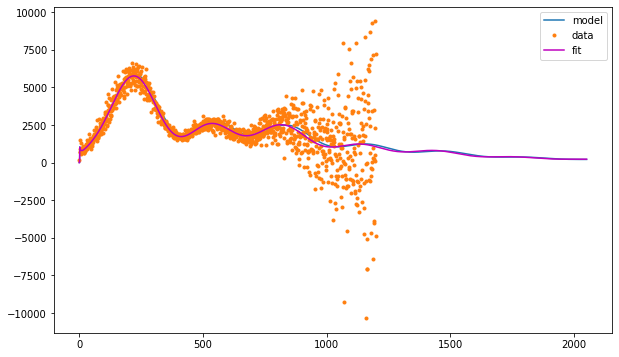

In [224]:
plt.figure(figsize=(10,6))

plt.plot(cmb, label='model')
plt.plot(data, '.', label='data')
plt.plot(get_spectrum_new(p_tau_cst), color='m', label='fit')
plt.legend()

Above is shown how the fit of the CMB using Newton’s method/Levenberg- Marquardt minimizer compares to the model. The two are in reasonnable agreement.

If we let $\tau$ float during the fit, we would expect the errors to increase, as the numner of DoFs in the fit increases as well. The fit realized with all 5 parameters floating for the MCMC seem to confirm that. 

# Question 4:

In a effort to better the initial guess, we first run the NLM code on the parameters, with all 6 parameters floating. The result will be the intial set of parameters in the MCMC chain, and the returned covariance matrix will be used for the step size.

In [17]:
#Running the code with τ floating:
cov, p = NLM(p2, λ=1, χ_0=2000)

The Chi square is 1588.2376465826746
The parameters are: H0=69.49515700069041, w_bh=0.02229028026848532, w_ch=0.11022767525606544, tau=0.0483075782242441, A_s=2.010834598611874e-09, n_s=0.968475952362454. 

The Chi square is 1231.7538442081088
The parameters are: H0=69.12468571901708, w_bh=0.022465909570938383, w_ch=0.1143106641668948, tau=0.041287996588577694, A_s=2.009950163392799e-09, n_s=0.9685950005171032. 

The Chi square is 1227.93394862296
The parameters are: H0=68.85272025703696, w_bh=0.022377642545447562, w_ch=0.1147106274682284, tau=0.021824568671702863, A_s=1.9318889066130113e-09, n_s=0.9659771907683451. 

The Chi square is 1227.9176541627514
The final parameters are:
H0=68.9+/-3.4
w_bh=0.0224+/-0.0008
w_ch=0.115+/-0.007
tau =0.0218+/-0.1472
A_s=1.9318889066130113e-09+/-5.785129660174104e-10
n_s=0.966+/-0.023


In [50]:
#WMAP data
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') 
index = wmap[:,0].astype(int)
data = wmap[:,1]
err = wmap[:,2]

###Model cmb
model=get_spectrum(p)[index]

Below is the code for the Monte-Carlo Markov Chain. Note that the assignment told us to reject steps where $\tau$ is negative, but to try and reduce the computing time, and increase the acceptance rate, my code re-draws trial parameters until $\tau$ is positive, instead of rejecting the step entirely.

In [236]:
def run_mcmc(pars, data, model, err, covariance, nstep=5000):
    rate = 0
    n = 0
    bar = ProgressBar(max_value=nstep)
    
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    χvec=np.zeros(nstep)
    
    χ_cur=ChiSq(model, data, err)
    r = np.linalg.cholesky(cov)
    
    for i in range(nstep):
        pars_trial = pars + np.dot(r,np.random.randn(r.shape[0]))*0.5
        
        while pars_trial[0,3]<0: #Check for negative tau before running the get_spectrum function. If tau<0, redraw until positive
            pars_trial = pars + np.dot(r,np.random.randn(r.shape[0]))*0.5

        model_trial = get_spectrum(pars_trial.transpose())[index]
        χ_trial = ChiSq(model_trial, data, err)
        n+=1
        
        #we now have chi^2 at our current location
        #and chi^2 in our trial location. decide if we take the step
        accept_prob = np.exp(-0.5*(χ_trial - χ_cur))
         
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars = pars_trial
            χ_cur = χ_trial
            rate += 1
        chain[i,:]=pars
        χvec[i]=χ_cur
        bar.update(i+1)
        
    print(f'The acceptance rate is: {rate/n *100}')
    return chain, χvec, rate

In [237]:
chain,chivec,rate=run_mcmc(p, data, model, err, cov, nstep=8000)

100% (8000 of 8000) |####################| Elapsed Time: 6:43:24 ETA:  00:00:00

The acceptance rate is: 27.525


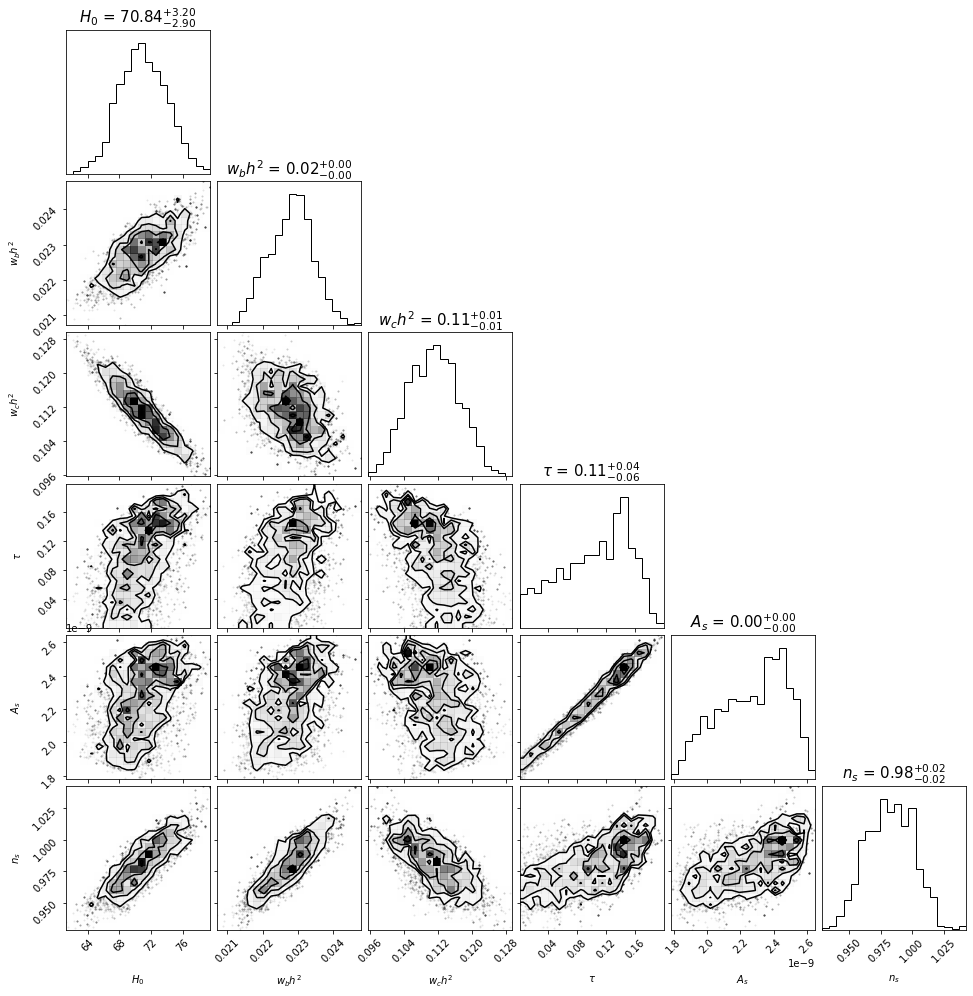

In [238]:
figure = corner.corner(chain, labels=[r"$H_0$", r"$w_bh^2$", r"$w_ch^2$", r"$\tau$", r"$A_s$", "$n_s$"],
                       show_titles=True, title_kwargs={"fontsize": 15})

Text(0.5, 1.0, 'MCMC chain for $n_s$')

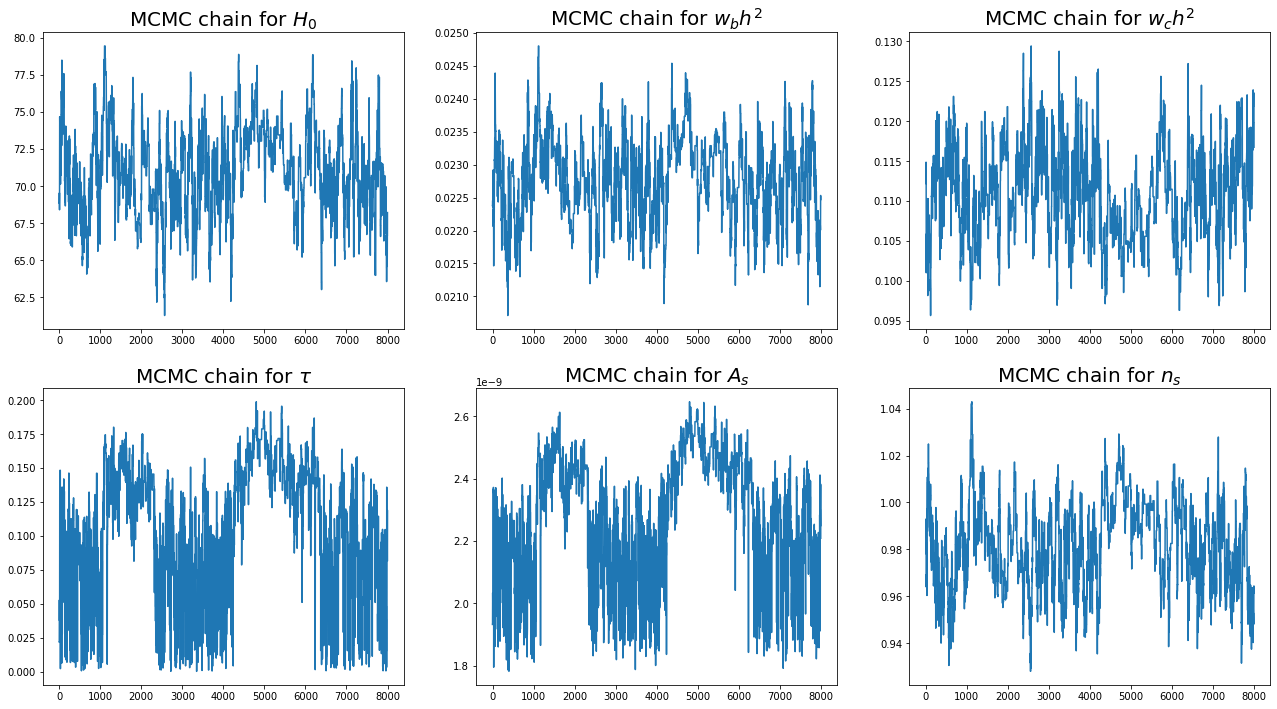

In [239]:
plt.figure(figsize=(22, 12))

plt.subplot(2,3,1)
plt.plot(chain[:,0])
plt.title(r'MCMC chain for $H_0$', fontsize=20)

plt.subplot(2,3,2)
plt.plot(chain[:,1])
plt.title(r'MCMC chain for $w_bh^2$', fontsize=20)

plt.subplot(2,3,3)
plt.plot(chain[:,2])
plt.title(r'MCMC chain for $w_ch^2$', fontsize=20)

plt.subplot(2,3,4)
plt.plot(chain[:,3])
plt.title(r'MCMC chain for $\tau$', fontsize=20)

plt.subplot(2,3,5)
plt.plot(chain[:,4])
plt.title(r'MCMC chain for $A_s$', fontsize=20)

plt.subplot(2,3,6)
plt.plot(chain[:,5])
plt.title(r'MCMC chain for $n_s$', fontsize=20)

While some of the chains resemble white noise, others have very strongly defined features. We note that them sharing features is a sign of correlation beween the parameters, correlation that we can also see in the corner plots above. 

Below we show the fourier transform of the chains:

Text(0.5, 1.0, 'Fourier MCMC chain for $n_s$')

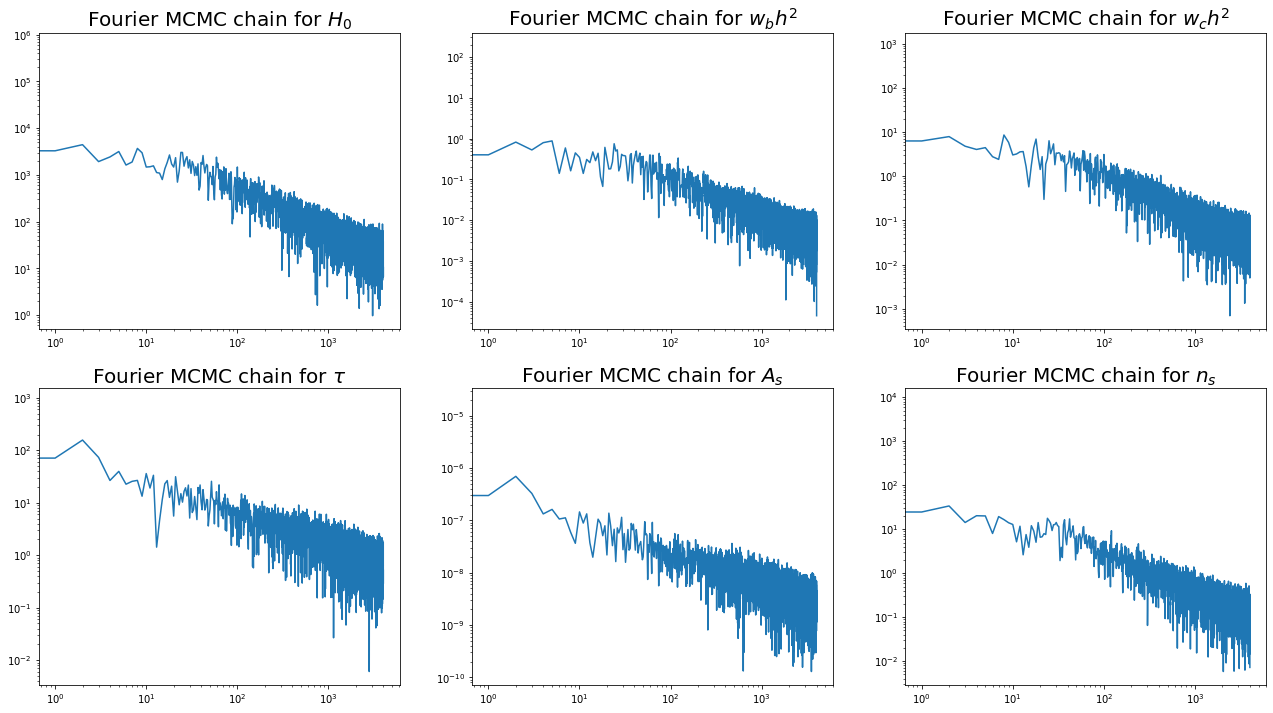

In [242]:
plt.figure(figsize=(22, 12))

plt.subplot(2,3,1)
plt.loglog(np.abs(np.fft.rfft(chain[:,0])))
plt.title(r'Fourier MCMC chain for $H_0$', fontsize=20)

plt.subplot(2,3,2)
plt.loglog(np.abs(np.fft.rfft(chain[:,1])))
plt.title(r'Fourier MCMC chain for $w_bh^2$', fontsize=20)

plt.subplot(2,3,3)
plt.loglog(np.abs(np.fft.rfft(chain[:,2])))
plt.title(r'Fourier MCMC chain for $w_ch^2$', fontsize=20)

plt.subplot(2,3,4)
plt.loglog(np.abs(np.fft.rfft(chain[:,3])))
plt.title(r'Fourier MCMC chain for $\tau$', fontsize=20)

plt.subplot(2,3,5)
plt.loglog(np.abs(np.fft.rfft(chain[:,4])))
plt.title(r'Fourier MCMC chain for $A_s$', fontsize=20)

plt.subplot(2,3,6)
plt.loglog(np.abs(np.fft.rfft(chain[:,5])))
plt.title(r'Fourier MCMC chain for $n_s$', fontsize=20)

So for all the parameters except $\tau$ and $A_s$, the real part of the fourier transform shows a plateau in the lower frequencies, which is a sign of convergence. $\tau$ and $A_s$ however are not converged properly. Let's look at the $\chi^2$s:

Text(0.5, 1.0, '$\\chi^2$')

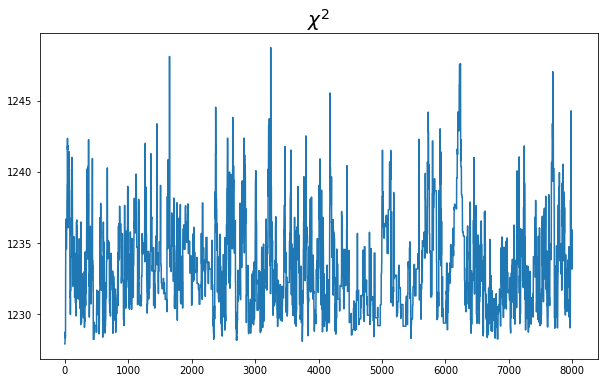

In [243]:
plt.figure(figsize=(10,6))
plt.plot(chivec)
plt.title(r'$\chi^2$', fontsize=20)

From the $\chi^2$ it looks like the fit converged correctly.
To get the errors on the parameters, since we cannot assume that they are Gaussian, we get the interval in which 68% of the values are contained; get the difference between the mean and those interval values, and the average of the two differences is our error:

In [244]:
p_final = np.mean(chain, axis=0) #these are the final parameters.
err_final = np.zeros(p_final.size)

for i in range(len(p_final)):
    pp = chain[:,i].copy()
    pp.sort()
    err_final[i] = ((p_final[i] - pp[int(0.157*len(pp))]) +(pp[int(0.843*len(pp))] - p_final[i]) )/2

In [245]:
print(f'The final parameters are:')
print(f'H0={p_final[0]:.1f}+/-{err_final[0]:.1f}')
print(f'w_bh={p_final[1]:.4f}+/-{err_final[1]:.4f}')
print(f'w_ch={p_final[2]:.3f}+/-{err_final[2]:.3f}')
print(f'tau ={p_final[3]:.4f}+/-{err_final[3]:.4f}')
print(f'A_s={p_final[4]}+/-{err_final[4]}')
print(f'n_s={p_final[5]:.3f}+/-{err_final[5]:.3f}')
print(f'Final Chi square is: {np.mean(chivec, axis=0)}')

The final parameters are:
H0=71.0+/-3.1
w_bh=0.0228+/-0.0007
w_ch=0.111+/-0.006
tau =0.1042+/-0.0527
A_s=2.2697710088303417e-09+/-2.2230503294154444e-10
n_s=0.982+/-0.019
Final Chi square is: 1233.1640406849504


# Question 5:

### Re-running the MCMC with a prior on $\tau$:

In [73]:
#This is the same code as in Q4, except the chi square was modified:
def run_mcmc_prior(pars, data, model, err, covariance, nstep=5000):
    rate = 0
    n = 0
    bar = ProgressBar(max_value=nstep)
    
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    χvec=np.zeros(nstep)
    
    χ_cur=ChiSq(model, data, err)
    r = np.linalg.cholesky(cov)
    
    for i in range(nstep):
        pars_trial = pars + np.dot(r,np.random.randn(r.shape[0]))*0.5
        
        while pars_trial[0,3]<0: #Check for negative tau before running the get_spectrum function. If tau<0, redraw until positive
            pars_trial = pars + np.dot(r,np.random.randn(r.shape[0]))*0.5

        model_trial = get_spectrum(pars_trial.transpose())[index]
        χ_trial = ChiSq(model_trial, data, err) + ((pars_trial[0,3] - 0.0544)/0.0073)**2
        n+=1
        
        #we now have chi^2 at our current location
        #and chi^2 in our trial location. decide if we take the step
        accept_prob = np.exp(-0.5*(χ_trial - χ_cur))
         
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars = pars_trial
            χ_cur = χ_trial
            rate += 1
        chain[i,:]=pars
        χvec[i]=χ_cur
        bar.update(i+1)

    print(f'The acceptance rate is: {rate/n *100}')
    return chain, χvec, rate

In [83]:
chain_prior,chivec_prior,rate_prior=run_mcmc_prior(p, data, model, err, cov, nstep=8000)

100% (8000 of 8000) |####################| Elapsed Time: 7:14:40 ETA:  00:00:00

The acceptance rate is: 12.0875


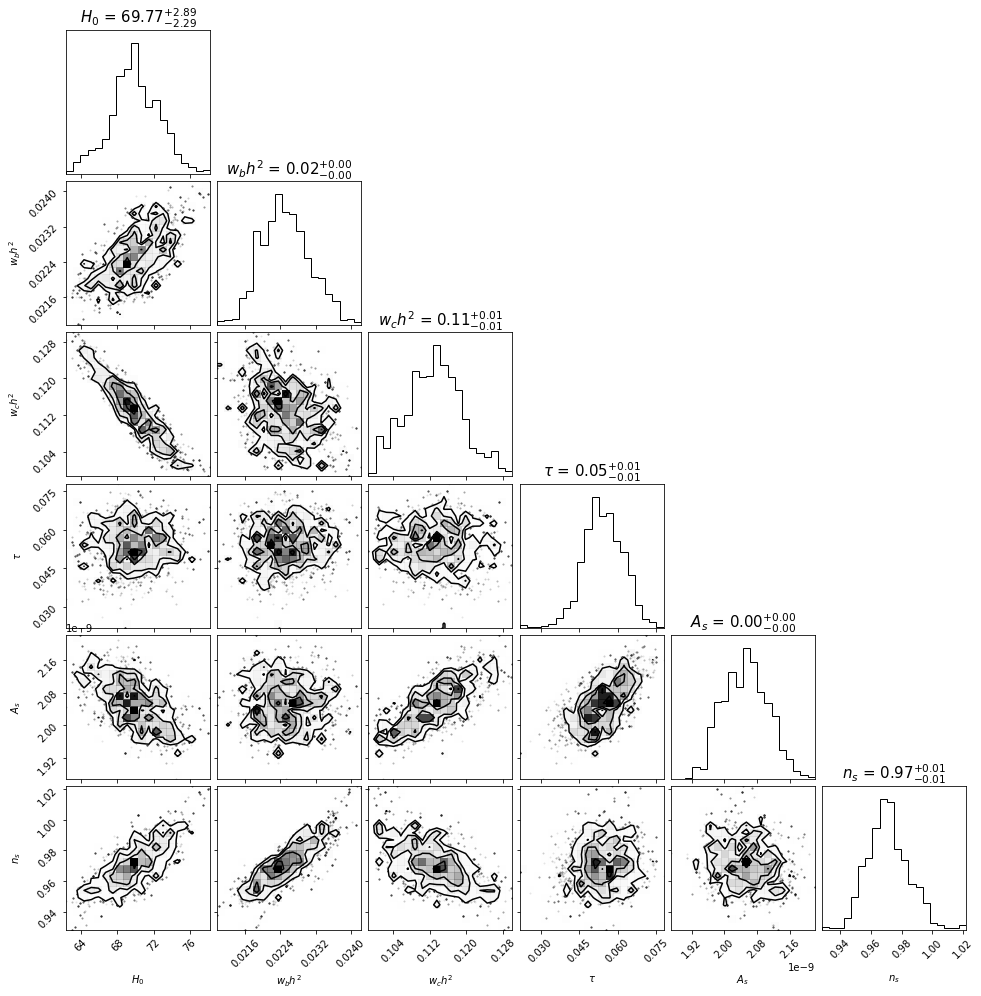

In [84]:
figure = corner.corner(chain_prior, labels=[r"$H_0$", r"$w_bh^2$", r"$w_ch^2$", r"$\tau$", r"$A_s$", "$n_s$"],
                       show_titles=True, title_kwargs={"fontsize": 15})

Text(0.5, 1.0, 'MCMC chain for $n_s$')

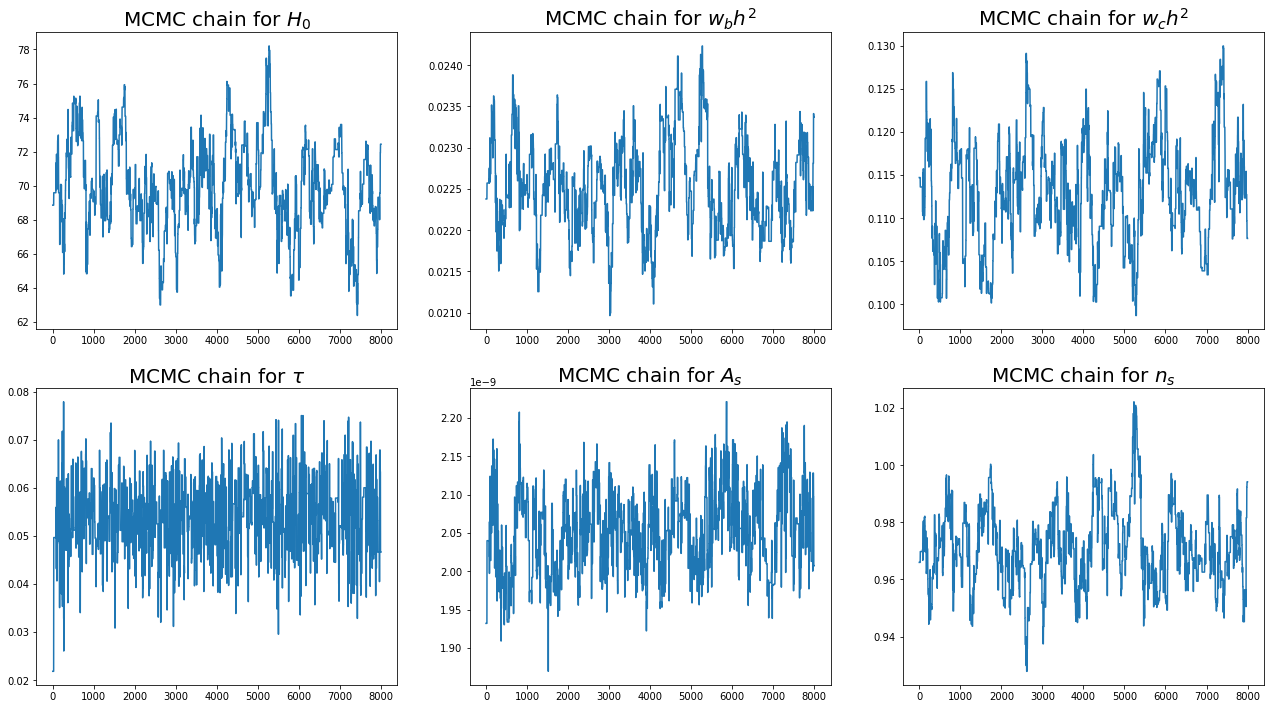

In [85]:
plt.figure(figsize=(22, 12))

plt.subplot(2,3,1)
plt.plot(chain_prior[:,0])
plt.title(r'MCMC chain for $H_0$', fontsize=20)

plt.subplot(2,3,2)
plt.plot(chain_prior[:,1])
plt.title(r'MCMC chain for $w_bh^2$', fontsize=20)

plt.subplot(2,3,3)
plt.plot(chain_prior[:,2])
plt.title(r'MCMC chain for $w_ch^2$', fontsize=20)

plt.subplot(2,3,4)
plt.plot(chain_prior[:,3])
plt.title(r'MCMC chain for $\tau$', fontsize=20)

plt.subplot(2,3,5)
plt.plot(chain_prior[:,4])
plt.title(r'MCMC chain for $A_s$', fontsize=20)

plt.subplot(2,3,6)
plt.plot(chain_prior[:,5])
plt.title(r'MCMC chain for $n_s$', fontsize=20)

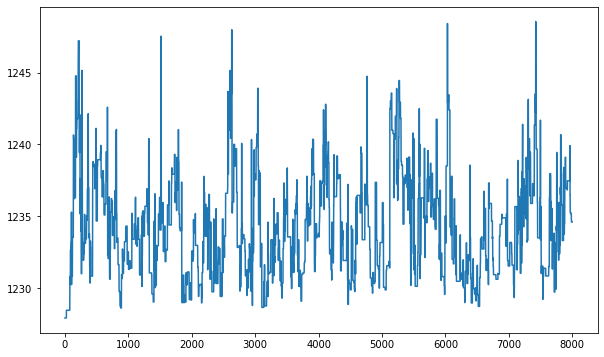

In [86]:
plt.figure(figsize=(10,6))
plt.plot(chivec_prior)

Looking at the $\chi^2$, which looks like white noise, and the chains themselves, which also look like white noise (mostly), we can say that the fit converged, or was close to. We no longer observe the very strong correlation features in $\tau$ and $A_s$. However, we note that the shape of the chains are much more defined than in Q4. This can be explained by the fact that the two chains were evaluated with 8000 points, but the second one had the prior on the $\chi^2$. This resulted in a much lower acceptance rate, and thus the chain is not entirely converged yet. Its mean $\chi^2$, printed below with the parameters, is also slightly higher.

In [140]:
p_final_prior = np.mean(chain_prior, axis=0) #these are the final parameters.
err_final_prior = np.zeros(p_final_prior.size)

for i in range(len(p_final_prior)):
    pp_prior = chain_prior[:,i].copy()
    pp_prior.sort()
    err_final_prior[i] = ((p_final_prior[i] - pp_prior[int(0.157*len(pp_prior))]) +(pp_prior[int(0.843*len(pp_prior))] - p_final_prior[i]) )/2

In [230]:
print(f'The final parameters are:')
print(f'H0={p_final_prior[0]:.1f}+/-{err_final_prior[0]:.1f}')
print(f'w_bh={p_final_prior[1]:.4f}+/-{err_final_prior[1]:.4f}')
print(f'w_ch={p_final_prior[2]:.3f}+/-{err_final_prior[2]:.3f}')
print(f'tau ={p_final_prior[3]:.4f}+/-{err_final_prior[3]:.4f}')
print(f'A_s={p_final_prior[4]}+/-{err_final_prior[4]}')
print(f'n_s={p_final_prior[5]:.3f}+/-{err_final_prior[5]:.3f}')
print(f'Final Chi square is: {np.mean(chivec_prior, axis=0)}')

The final parameters are:
H0=69.9+/-2.6
w_bh=0.0225+/-0.0006
w_ch=0.113+/-0.006
tau =0.0544+/-0.0076
A_s=2.0524452898205756e-09+/-5.895650040147758e-11
n_s=0.971+/-0.014
Final Chi square is: 1234.1555263761782


### Importance Sampling:

Another way to take into account the existence of a prior on $\tau$ is to weight the parameter by their closeness to the prior, defined by a Gaussian with mean $0.0544$ and sigma $0.0073$.

In [247]:
#defining the weightint function:
def WeightGauss(x,μ,σ):
    return (1/ (np.sqrt(2*np.pi) * σ)) * np.exp(-np.power(x - μ, 2.) / (2 * np.power(σ, 2.)))

In [252]:
μ = 0.0544
σ = 0.0073

weighted_tau = WeightGauss(chain[:,3], μ, σ) #Get the weights from the prior

weighted_p = np.average(chain, axis=0, weights = weighted_tau) #final weighted parameters

weighted_cov = np.zeros(chain.shape) #get the new errors from the weighted covariance matrix
for i in range(len(chain.T)):
    weighted_cov[:,i] = np.cov(chain[:,i], aweights = weighted_tau)  
err_weighted_p = np.sqrt(np.diag(weighted_cov))

In [253]:
print(f'The final parameters from importance sampling are:')
print(f'H0={weighted_p[0]:.1f}+/-{err_weighted_p[0]:.1f}')
print(f'w_bh={weighted_p[1]:.4f}+/-{err_weighted_p[1]:.4f}')
print(f'w_ch={weighted_p[2]:.3f}+/-{err_weighted_p[2]:.3f}')
print(f'tau ={weighted_p[3]:.4f}+/-{err_weighted_p[3]:.4f}')
print(f'A_s={weighted_p[4]}+/-{err_weighted_p[4]}')
print(f'n_s={weighted_p[5]:.3f}+/-{err_weighted_p[5]:.3f}')

The final parameters from importance sampling are:
H0=69.5+/-2.6
w_bh=0.0225+/-0.0006
w_ch=0.114+/-0.005
tau =0.0547+/-0.0070
A_s=2.0625912515506042e-09+/-4.366925144065948e-11
n_s=0.970+/-0.017


Therefore we have three sets of best fit parameters for the CMB, which are all in pretty good agreement. In both case with the prior on $\tau$, we can observe than all the other parameters recalibrate, to almost the same values.

### General plot with all three fits:

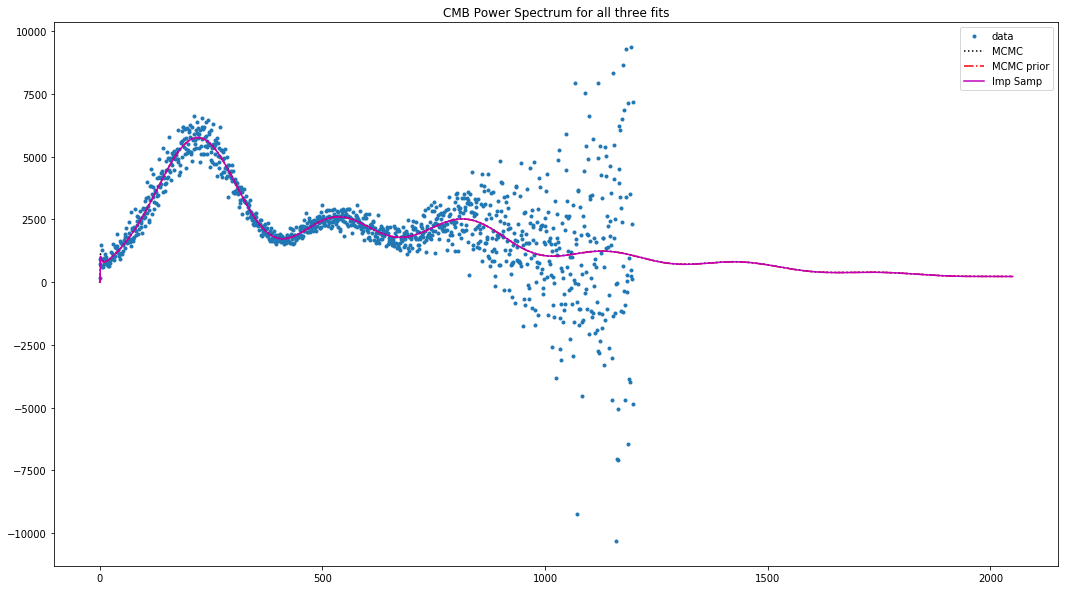

In [250]:
plt.figure(figsize=(18,10))

plt.plot(data, '.',label='data')
plt.plot(get_spectrum_new(p_final),':', color='k', label='MCMC')
plt.plot(get_spectrum_new(p_final_prior),'-.', color='r', label='MCMC prior')
plt.plot(get_spectrum_new(weighted_p), '-', color='m',label='Imp Samp')
plt.title('CMB Power Spectrum for all three fits')
plt.legend()